In [1]:
#Import the required libraries
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = os.chdir('/content/drive/MyDrive/MajorProjectData/')

In [4]:
# Get the names of all classes/categories.
all_classes_names = os.listdir(data_dir)

In [5]:
all_classes_names

['Explosion', 'StreetFights', 'RoadAccident', 'CRNN_model_structure_plot.png']

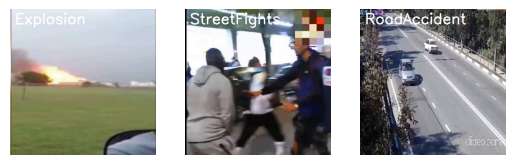

In [9]:
# Define the number of iterations or frames you want to display
num_iterations = 3

# Generate a random range of indices
random_range = random.sample(range(len(all_classes_names)), num_iterations)

# Set a fixed size for the displayed frames
frame_size = (300, 300)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/MajorProjectData/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_path = f'/content/drive/MyDrive/MajorProjectData/{selected_class_Name}/{selected_video_file_name}'
    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        continue

    video_reader = cv2.VideoCapture(video_path)

    if not video_reader.isOpened():
        print(f"Could not open video: {video_path}")
        continue

    _, bgr_frame = video_reader.read()

    video_reader.release()

    if bgr_frame is None:
        print(f"Error reading frame from video: {video_path}")
        continue

    # Resize the frame to the fixed size
    resized_frame = cv2.resize(bgr_frame, frame_size)

    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(1, 3, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

plt.show()

In [10]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 128,128

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

DATASET_DIR = '/content/drive/MyDrive/MajorProjectData/'

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =  ['Explosion', 'StreetFights', 'RoadAccident']

In [11]:
def frames_extraction(video_path):

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [12]:
def create_dataset():

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [13]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Explosion
Extracting Data of Class: StreetFights
Extracting Data of Class: RoadAccident


In [14]:
np.save("/content/drive/MyDrive/MajorProjectExtras/features.npy",features)
np.save("/content/drive/MyDrive/MajorProjectExtras/labels.npy",labels)
np.save("/content/drive/MyDrive/MajorProjectExtras/video_files_paths.npy",video_files_paths)

In [15]:
one_hot_encoded_labels = to_categorical(labels)

In [16]:
seed_constant = 42 # Choose a random seed for reproducibility

In [17]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
X_train, X_test, Y_train, Y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.3, shuffle = True, random_state = seed_constant)

In [18]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense

def create_cnn_model():
    model3 = Sequential()

    model3.add(Conv3D(32, (3, 3, 3), activation='relu', input_shape=X_train.shape[1:]))
    model3.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model3.add(TimeDistributed(Dropout(0.2)))

    model3.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model3.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model3.add(TimeDistributed(Dropout(0.2)))

    model3.add(Flatten())
    model3.add(Dense(len(CLASSES_LIST), activation="softmax"))

    model3.summary()

    return model3

cnn_model = create_cnn_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 126, 126, 32   2624      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 18, 63, 63, 32)    0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 18, 63, 63, 32)    0         
 ributed)                                                        
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 61, 61, 32)    27680     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 16, 31, 31, 32)    0         
 g3D)                                                   

In [19]:
# Construct the required CNN model.
cnn_model = create_cnn_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 18, 126, 126, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 18, 63, 63, 32)    0         
 g3D)                                                            
                                                                 
 time_distributed_2 (TimeDi  (None, 18, 63, 63, 32)    0         
 stributed)                                                      
                                                                 
 conv3d_3 (Conv3D)           (None, 16, 61, 61, 32)    27680     
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 16, 31, 31, 32)    0         
 g3D)                                                 

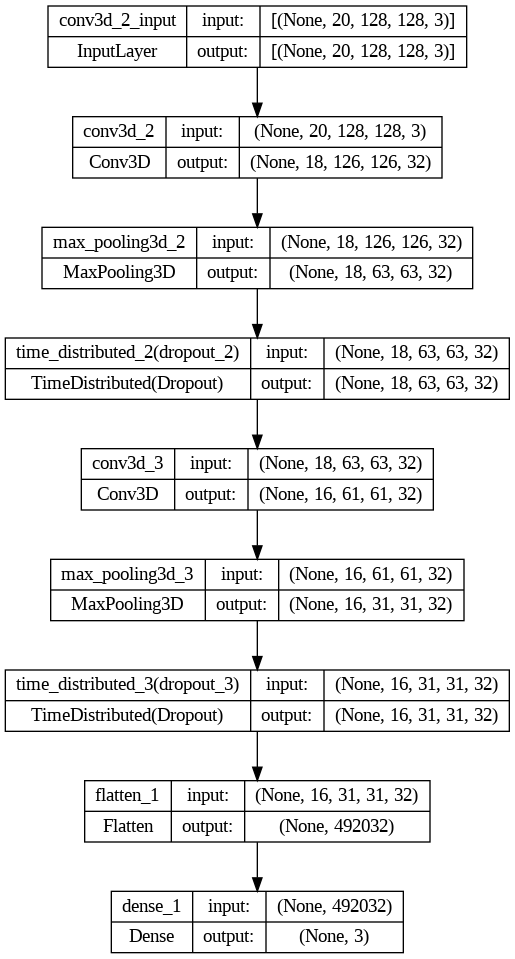

In [20]:
plot_model(cnn_model, to_file = 'CNN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [37]:
import time

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics values to the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

# Start the timer
start_time = time.time()

# Start training the model
history = cnn_model.fit(x=X_train, y=Y_train, epochs=15, batch_size=30, shuffle=True, validation_split=0.18, callbacks=[early_stopping_callback])

Epoch 1/15
2/2 [==============================] - 5s 3s/step - loss: 0.2779 - accuracy: 0.8500 - val_loss: 0.8717 - val_accuracy: 0.7778
Epoch 2/15
2/2 [==============================] - 1s 302ms/step - loss: 3.8707e-04 - accuracy: 1.0000 - val_loss: 16.1525 - val_accuracy: 0.3333
Epoch 3/15
2/2 [==============================] - 1s 299ms/step - loss: 2.4201 - accuracy: 0.7500 - val_loss: 3.3599 - val_accuracy: 0.5556
Epoch 4/15
2/2 [==============================] - 1s 302ms/step - loss: 1.6966 - accuracy: 0.7750 - val_loss: 0.5127 - val_accuracy: 0.8889
Epoch 5/15
2/2 [==============================] - 1s 297ms/step - loss: 5.6382e-06 - accuracy: 1.0000 - val_loss: 1.7471 - val_accuracy: 0.6667
Epoch 6/15
2/2 [==============================] - 1s 295ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 3.9278 - val_accuracy: 0.4444
Epoch 7/15
2/2 [==============================] - 1s 299ms/step - loss: 0.1552 - accuracy: 0.9500 - val_loss: 4.9208 - val_accuracy: 0.4444
Epoch 8/15
2/2

In [38]:
# Calculate the training time
training_time = time.time() - start_time
print("Training Time: {:.2f} seconds".format(training_time)) #rerun zal ahe actually it is 210 smtng

Training Time: 15.58 seconds


In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

# Use the trained model to predict the classes for the training set
Y_pred_train = cnn_model.predict(X_train)

# Convert the one-hot-encoded vectors back to class labels
Y_train_labels = np.argmax(Y_train, axis=1)
Y_pred_train_labels = np.argmax(Y_pred_train, axis=1)

# Calculate the accuracy of the model on the training set
accuracy_train = accuracy_score(Y_train_labels, Y_pred_train_labels)

# Calculate the precision, recall, sensitivity, specificity, and AUC of the model on the training set
# Calculate the precision, recall, sensitivity, specificity, and AUC of the model on the training set
precision_train = precision_score(Y_train_labels, Y_pred_train_labels, average='weighted')
recall_train = recall_score(Y_train_labels, Y_pred_train_labels, average='weighted')


sensitivity_train = recall_score(Y_train_labels, Y_pred_train_labels, average='weighted', pos_label=1)
specificity_train = recall_score(Y_train_labels, Y_pred_train_labels, average='weighted', pos_label=0)
fpr_train_1, tpr_train_1 , _ = roc_curve(Y_train.ravel(), Y_pred_train.ravel(), pos_label=1)
auc_score_train_1 = auc(fpr_train_1, tpr_train_1)

# Generate a classification report for the training set
print("Classification Report (training set):\n")
print(classification_report(Y_train_labels, Y_pred_train_labels, target_names=CLASSES_LIST))

# Print the accuracy, precision, recall, sensitivity, specificity, and AUC values for the training set
print("Accuracy (training set): {:.2f}".format(accuracy_train))
print("Precision (training set): {:.2f}".format(precision_train))
print("Recall (training set): {:.2f}".format(recall_train))
print("Sensitivity (training set): {:.2f}".format(sensitivity_train))
print("Specificity (training set): {:.2f}".format(specificity_train))

2/2 [==============================] - 0s 194ms/step
Classification Report (training set):

              precision    recall  f1-score   support

   Explosion       1.00      0.92      0.96        12
StreetFights       0.94      1.00      0.97        15
RoadAccident       1.00      1.00      1.00        22

    accuracy                           0.98        49
   macro avg       0.98      0.97      0.97        49
weighted avg       0.98      0.98      0.98        49

Accuracy (training set): 0.98
Precision (training set): 0.98
Recall (training set): 0.98
Sensitivity (training set): 0.98
Specificity (training set): 0.98


In [40]:

# Use the trained model to predict the classes for the test set
Y_pred_test = cnn_model.predict(X_test)

# Convert the one-hot-encoded vectors back to class labels
Y_test_labels = np.argmax(Y_test, axis=1)
Y_pred_test_labels = np.argmax(Y_pred_test, axis=1)

# Calculate the accuracy of the model on the test set
accuracy_test = accuracy_score(Y_test_labels, Y_pred_test_labels)

# Calculate the precision, recall, sensitivity, specificity, and AUC of the model on the test set
precision_test = precision_score(Y_test_labels, Y_pred_test_labels, average='weighted')
recall_test = recall_score(Y_test_labels, Y_pred_test_labels, average='weighted')
sensitivity_test = recall_score(Y_test_labels, Y_pred_test_labels, average='weighted', pos_label=1)
specificity_test = recall_score(Y_test_labels, Y_pred_test_labels, average='weighted', pos_label=0)
fpr_test_1, tpr_test_1 , _ = roc_curve(Y_test.ravel(), Y_pred_test.ravel(), pos_label=1)
auc_score_test_1 = auc(fpr_test_1, tpr_test_1)

# Generate a classification report for the test set
print("Classification Report (test set):\n")
print(classification_report(Y_test_labels, Y_pred_test_labels, target_names=CLASSES_LIST))

# Print the accuracy, precision, recall, sensitivity, specificity, and AUC values for the test set
print("Accuracy (test set): {:.2f}".format(accuracy_test))
print("Precision (test set): {:.2f}".format(precision_test))
print("Recall (test set): {:.2f}".format(recall_test))
print("Sensitivity (test set): {:.2f}".format(sensitivity_test))
print("Specificity (test set): {:.2f}".format(specificity_test))

1/1 [==============================] - 0s 91ms/step
Classification Report (test set):

              precision    recall  f1-score   support

   Explosion       0.62      0.62      0.62         8
StreetFights       0.57      0.80      0.67         5
RoadAccident       1.00      0.75      0.86         8

    accuracy                           0.71        21
   macro avg       0.73      0.72      0.72        21
weighted avg       0.76      0.71      0.72        21

Accuracy (test set): 0.71
Precision (test set): 0.76
Recall (test set): 0.71
Sensitivity (test set): 0.71
Specificity (test set): 0.71


In [41]:
model_evaluation_history = cnn_model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 176ms/step - loss: 3.2247 - accuracy: 0.7143


In [26]:
labels_predict = cnn_model.predict(X_test)

1/1 [==============================] - 0s 161ms/step


In [42]:
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(Y_test , axis=1)

In [43]:
labels_test_normal.shape , labels_predict.shape

((21,), (21,))

In [44]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.5238095238095238


In [45]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.38      0.38      0.38         8
           1       0.33      0.20      0.25         5
           2       0.70      0.88      0.78         8

    accuracy                           0.52        21
   macro avg       0.47      0.48      0.47        21
weighted avg       0.49      0.52      0.50        21



In [46]:
cnn_model.save("/content/drive/MyDrive/Augmented Data /CNN_ModelAugmented__.h5")

In [51]:
# data_dir = os.chdir('/content/drive/MyDrive/B.TECH_SEM_2/Fighting/V_49_outputhorizontal.mp4')

In [47]:
import cv2
import random
import matplotlib.pyplot as plt

plt.style.use("default")

def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20,15))

    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()

        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.axis('off')  # Turn off axis
        plt.subplots_adjust(wspace=0, hspace=0)  # Adjust spacing
        plt.tight_layout()

    video_reader.release()
    plt.show()  # Show the plot




In [48]:
# Usage
pred_video_path = '/content/drive/MyDrive/MajorProjectData/StreetFights/streetfight_16.mp4'
show_pred_frames(pred_video_path)

Output hidden; open in https://colab.research.google.com to view.

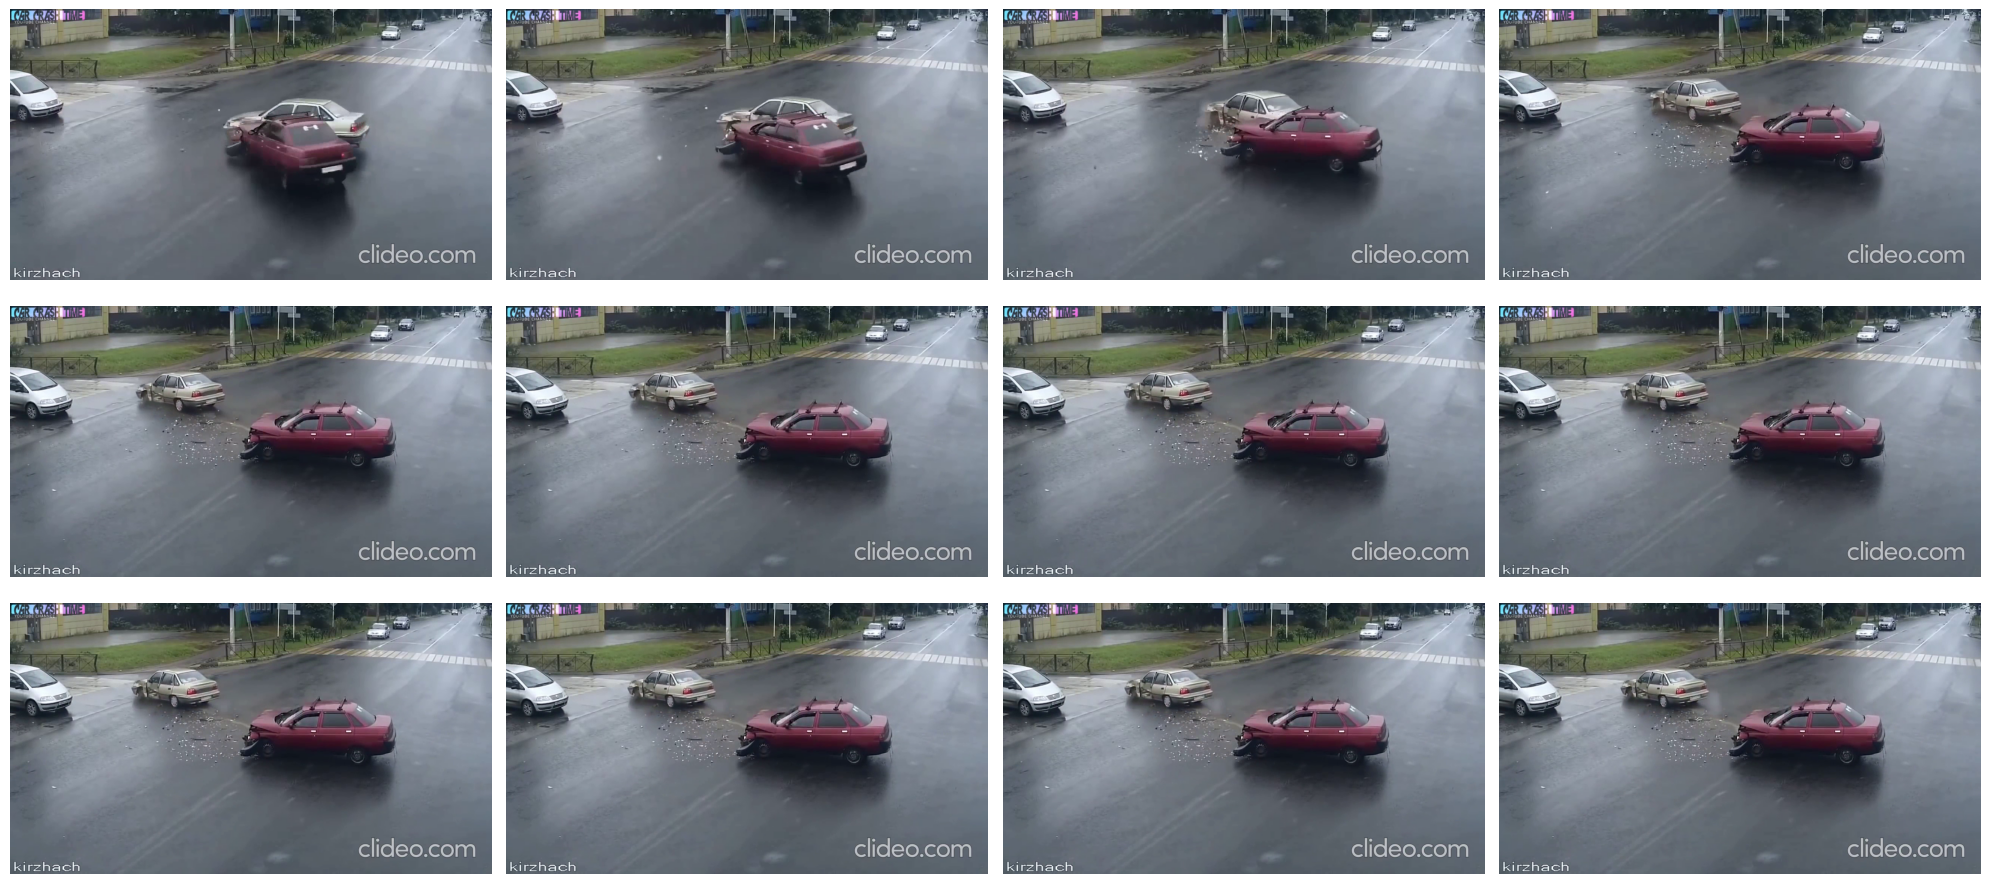

In [49]:
# Usage
pred_video_path = '/content/drive/MyDrive/MajorProjectData/RoadAccident/RoadAccident_16.mp4'
show_pred_frames(pred_video_path)

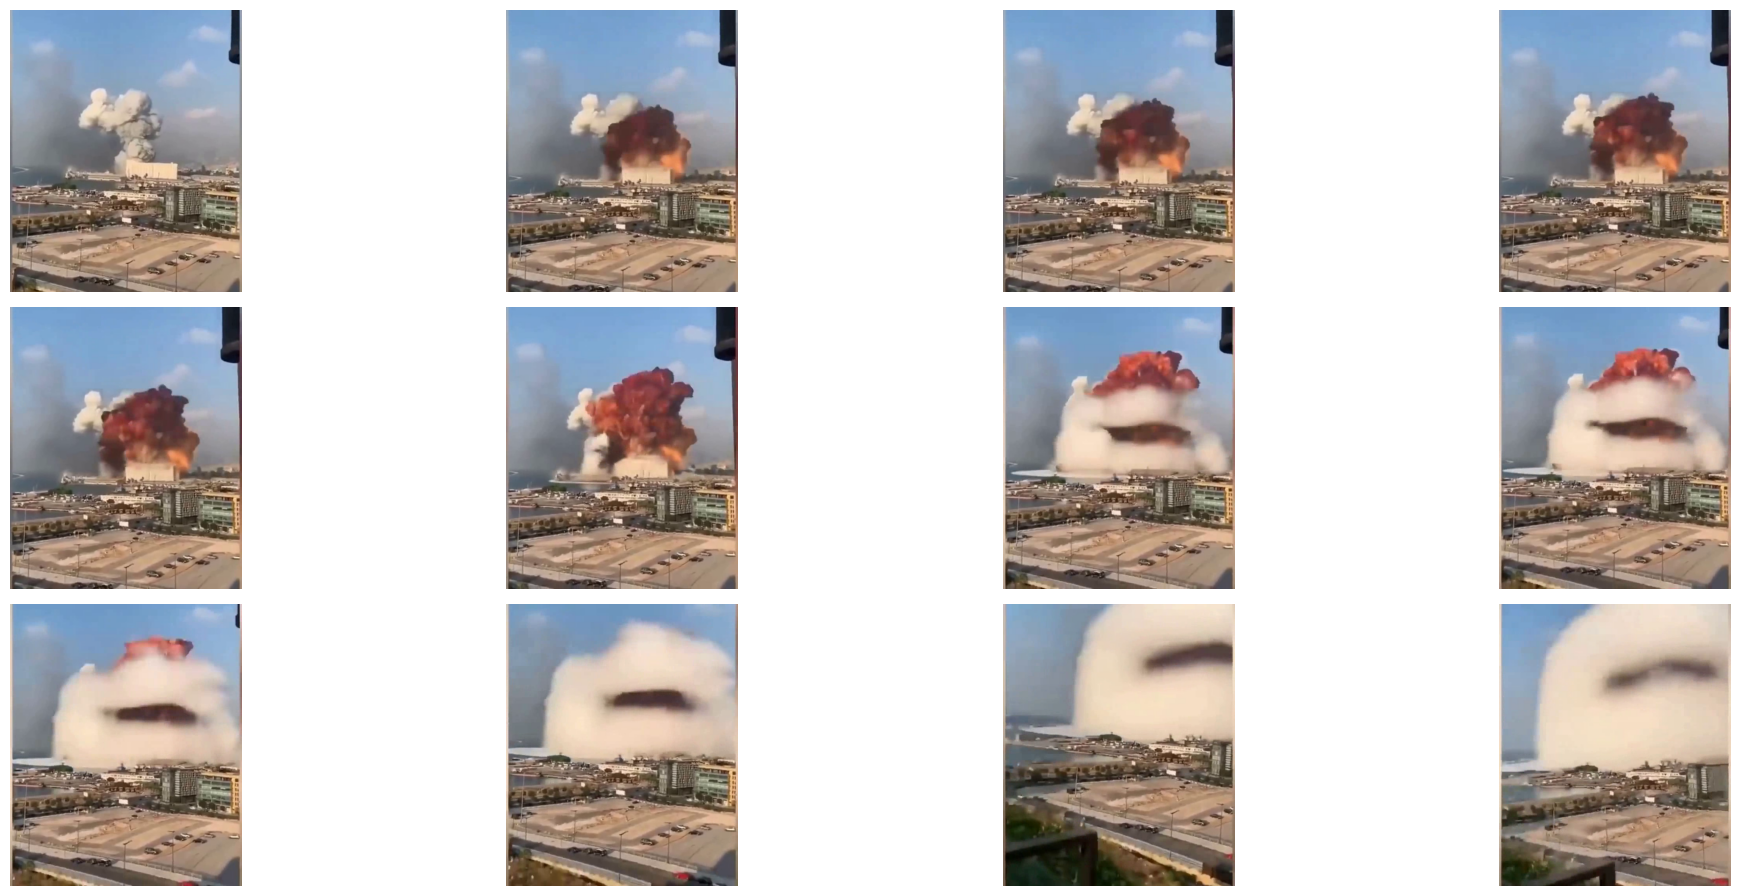

In [50]:
# Usage
pred_video_path = '/content/drive/MyDrive/MajorProjectData/Explosion/explosion_16.mp4'
show_pred_frames(pred_video_path)